In [1]:
from nltk.tokenize import RegexpTokenizer
import numpy as np
import re

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import GRU
np.random.seed(7)

Using TensorFlow backend.


In [2]:
import pandas as pd
df = pd.read_csv('../Dataset/complaints.csv')
df.head()

,Consumer complaint narrative,Product
0,I have outdated information on my credit repor...,Credit reporting
1,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan
2,An account on my credit report has a mistaken ...,Credit reporting
3,This company refuses to provide me verificatio...,Debt collection
4,This complaint is in regards to Square Two Fin...,Debt collection


### Tokenizer
Regular expression based tokenizers to consider only alphabetical sequences and ignore numerical sequences.

In [3]:
def complaint_to_words(comp):
    
    words = RegexpTokenizer('\w+').tokenize(comp)
    words = [re.sub(r'([xx]+)|([XX]+)|(\d+)', '', w).lower() for w in words]
    words = list(filter(lambda a: a != '', words))
    
    return words

### Vocabulary

In [4]:
all_words = list()
for comp in df['Consumer complaint narrative']:
    for w in complaint_to_words(comp):
        all_words.append(w)

In [5]:
print('Size of vocabulary: {}'.format(len(set(all_words))))

Size of vocabulary: 76908


In [6]:
print('Complaint\n', df['Consumer complaint narrative'][10], '\n')
print('Tokens\n', complaint_to_words(df['Consumer complaint narrative'][10]))

Complaint
 Without provocation, I received notice that my credit line was being decreased by nearly 100 %. My available credit was reduced from $ XXXX to XXXX ( the rough amount of my available balance ). 

When I called to question the change, I was provided a nob-descript response referencing my XXXX report. It was my understanding that under the FCRA I was entitled to a copy of this report, but was refused by Citi and have been given no further explanation. 

This is predatory in that it affects my utilization of credit, further subjecting me to increase in APrs, etc and a higher cost of credit without any reason. 

Tokens
 ['without', 'provocation', 'i', 'received', 'notice', 'that', 'my', 'credit', 'line', 'was', 'being', 'decreased', 'by', 'nearly', 'my', 'available', 'credit', 'was', 'reduced', 'from', 'to', 'the', 'rough', 'amount', 'of', 'my', 'available', 'balance', 'when', 'i', 'called', 'to', 'question', 'the', 'change', 'i', 'was', 'provided', 'a', 'nob', 'descript', 'resp

### Indexing
Indexing each word in the vocabulary

In [7]:
index_dict = dict()
count = 1
index_dict['<unk>'] = 0
for word in set(all_words):
    index_dict[word] = count
    count += 1

### Dataset
Utilizing indexed words to replace words by index. This makes the dataset numerical and keras readable.

In [8]:
data_list = list()
for comp in df['Consumer complaint narrative']:
    l = list()
    for w in complaint_to_words(comp):
        l.append(index_dict[w])
    data_list.append(l)

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['Product'])
df['Target'] = le.transform(df['Product'])
df.head()

,Consumer complaint narrative,Product,Target
0,I have outdated information on my credit repor...,Credit reporting,5
1,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan,2
2,An account on my credit report has a mistaken ...,Credit reporting,5
3,This company refuses to provide me verificatio...,Debt collection,7
4,This complaint is in regards to Square Two Fin...,Debt collection,7


### One hot Encoding

In [10]:
from keras.utils.np_utils import to_categorical
y_binary = to_categorical(df['Target'].values)
y_binary.shape

(179776, 18)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(data_list), y_binary, 
    test_size=0.15, random_state=0)

### Computation Graph Limitations

In [12]:
len(X_train[0]), len(X_train[1]), len(X_train[2])

(231, 77, 681)

In [13]:
# truncate and pad input sequences
max_review_length = 750
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [14]:
len(X_train[0]), len(X_train[1]), len(X_train[2])

(750, 750, 750)

In [15]:
# create the model
top_words = len(set(all_words))
embedding_vecor_length = 300
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(18, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=256)
model.save_weights('../weights/model_lstm.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 750, 300)          23072400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 750, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                594       
Total params: 23,115,618
Trainable params: 23,115,618
Non-trainable params: 0
_________________________________________________________________
None
Train on 152809 samples, validate on 26967 samples
Epoch 1/5
152809/152809 [==============================] - 463s 3ms/step -

### GRU Unit
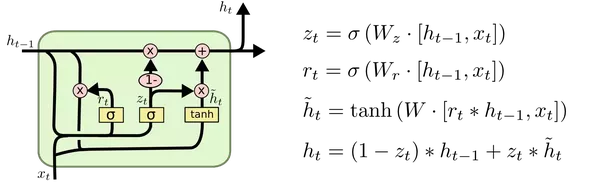

In [16]:
# create the model
top_words = len(set(all_words))
embedding_vecor_length = 100
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(GRU(32))
model.add(Dropout(0.2))
model.add(Dense(18, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=256)
model.save_weights('../weights/model_gru.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 750, 100)          7690800   
_________________________________________________________________
dropout_3 (Dropout)          (None, 750, 100)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)                594       
Total params: 7,704,162
Trainable params: 7,704,162
Non-trainable params: 0
_________________________________________________________________
None
Train on 152809 samples, validate on 26967 samples
Epoch 1/5
152809/152809 [==============================] - 400s 3ms/step - l

In [17]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 82.62%


In [18]:
embeddings_index = {}
f = open('../Dataset/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [21]:
from spellchecker import SpellChecker
spell = SpellChecker()

unknown_words = list()
embedding_matrix = np.zeros((len(set(all_words)) + 1, 300))
for word, i in index_dict.items():
#     word = spell.correction(word)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        unknown_words.append(word)

In [22]:
len(unknown_words), len(set(all_words))

(41439, 76908)

In [24]:
# create the model
top_words = len(set(all_words)) + 1
embedding_vecor_length = 300
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, 
                    input_length=max_review_length, 
                    weights=[embedding_matrix]))
model.add(Dropout(0.2))
model.add(GRU(32))
model.add(Dropout(0.2))
model.add(Dense(18, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=256)
model.save_weights('../weights/model_glove.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 750, 300)          23072700  
_________________________________________________________________
dropout_5 (Dropout)          (None, 750, 300)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                31968     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 18)                594       
Total params: 23,105,262
Trainable params: 23,105,262
Non-trainable params: 0
_________________________________________________________________
None
Train on 152809 samples, validate on 26967 samples
Epoch 1/5
152809/152809 [==============================] - 379s 2ms/step -